In [28]:
import time
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder

EARLY_STOP_ACC_TOL = 0.01

# Synthetic Dataset Construction

In [29]:
## Initialize random data (A matrix)
m = 1000 # number of examples
d = 1000 # dim of example
k = 50 # number of output classes
# Data init
A = np.random.normal(0,1,size=(m,d)) # (# examples, dim examples)
# Param init
X = np.random.normal(0,1,size=(d,k)) # (dim examples, # classes)
E = np.random.normal(0,1,size=(m,k)) 
# Generate target classes
#b_i = np.random.randint(1, k+1, size=(m,1))
#b_i_zeroidx = b_i - 1
I_k = np.eye(k)

# This is a kinda strange way of generating data
b = np.dot(A,X) + E # (m,k)
b_i = b.argmax(axis=1) # zero indexed!
b_onehot = I_k[b_i]

# Each model will use the same initial parameters, but different than the ones used to generate the toy data.
X0 = np.random.normal(0,1,size=(d,k))
#X0 = np.zeros_like(X)

In [30]:
# for sanity
num_examples = m
example_dim = d
num_classes = k


# Full Gradient Descent

In [31]:
def grad(A, Y, X):
    Z = - A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    grad_X = 1/m * (A.T @ (Y - probs))
    return grad_X

def loss(A, Y, X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    num_samples = A.shape[0]
    loss = 1/num_samples * (np.trace(A @ X @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def fast_loss(A, Y, X, Z=None):
    if Z is None:
        Z = -A @ X  # Compute Z only if not provided
    num_samples = A.shape[0]

    # Efficient computation of the trace term
    AX = A @ X
    trace_term = np.sum(AX * Y)

    # Efficient and stable log-sum-exp computation
    log_sum_exp = logsumexp(Z, axis=1)

    # Final computation of the loss
    loss = 1 / num_samples * (trace_term + np.sum(log_sum_exp))
    return loss

def accuracy(X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    predictions = softmax(Z)
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = b_i #np.argmax(b_onehot, axis=1)
    accuracy = np.mean(predicted_labels == actual_labels)
    return accuracy

def gd(A, b_onehot, max_iter=1000, step_size=0.1):
    X_cur = np.copy(X0)
    start_time_p = time.process_time()
    start_time_w = time.time()
    hist = []
    for i in range(max_iter):
        g = grad(A, b_onehot, X_cur)
        X_cur -= step_size * g
        Z = - A @ X_cur
        # Note that calculating metrics takes CPU time
        # When compairng histories, should calculate roughly the same maetics 
        hist_row = {
            'iter': i,
            'loss': loss(A, b_onehot, X_cur ,Z),
            'accuracy': accuracy(X_cur, Z),
            'grad_mag': np.linalg.norm(g, 2),
            'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
            'wall_time': time.time() - start_time_w
            }
        hist.append(hist_row)
        if 1 -  hist_row['accuracy'] < EARLY_STOP_ACC_TOL:
            break

    hist_df = pd.DataFrame(hist)
    return hist_df

In [32]:
def F_norm(A):
    return np.dot(A.T, A)

def lipschitz_approx(A):
    H = F_norm(A)
    eigenvalues = np.linalg.eigvalsh(H)
    return np.max(np.abs(eigenvalues))

# Example usage
L = lipschitz_approx(A)
print("Approximated Lipschitz constant:", L)

Approximated Lipschitz constant: 3957.955258463091


In [33]:
1/L

0.0002526557110168822

In [36]:
hist_gd_df = gd(A,b_onehot, step_size=3.3)
hist_gd_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,66.480330,0.026,0.280555,0.265625,0.118165
1,1,60.097216,0.038,0.269370,0.484375,0.196672
2,2,54.159715,0.056,0.257890,0.609375,0.237322
3,3,48.631375,0.074,0.247999,0.859375,0.271443
4,4,43.486900,0.098,0.241753,1.046875,0.295639
5,5,38.738653,0.131,0.233802,1.171875,0.325706
6,6,34.335689,0.164,0.224256,1.281250,0.341351
7,7,30.247478,0.206,0.218396,1.390625,0.372618
8,8,26.508235,0.250,0.210686,1.562500,0.396255
9,9,23.096383,0.304,0.202076,1.671875,0.423334


Sources:
https://towardsdatascience.com/multiclass-logistic-regression-from-scratch-9cc0007da372

# BCGD

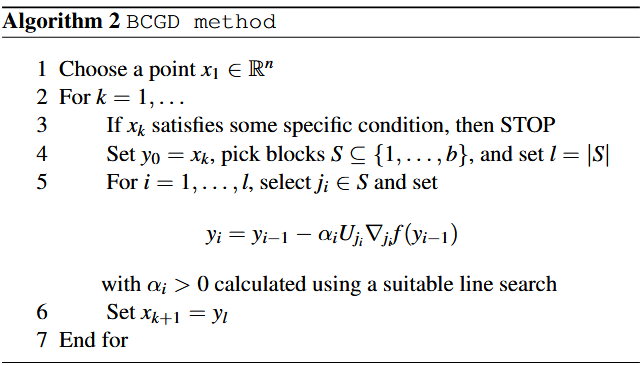

In [38]:
L = 0.01
alpha = 1/L

In [37]:
# TODO: implement a faster version that calculates just the ith component
def gs_coord_select(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 0)) # select the coord (col)
    g_ik = g[:,i_k].reshape((example_dim,1))
    return g_ik, i_k

def coord_step(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    #X_out = X0
    X0[:,i_k] += step.flatten()
    return {'step_size':alpha}#X_out

def gs_coord_select_T(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 1)) # select the coord (row)
    
    g_ik = g[i_k,:].reshape((num_classes,1))
    return g_ik, i_k

def coord_step_T(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    X_out = X0
    X_out[i_k,:] += step.flatten()
    return X_out


# TODO: check optimality condition for early stopping.
def BCGD(coord_select, coord_step=coord_step, max_iter = 100, return_hist = True, step_size = alpha):
    # X_DEBUG = None
    X_cur = np.copy(X0)
    hist = []
    start_time_p = time.process_time()
    start_time_w = time.time()
    for iter in range(max_iter):
        hist_iter = {'iter': iter}
        g_ik, i_k = coord_select(X_cur)
        #X_cur = coord_step(X_cur, i_k, g_ik)
        step_stats = coord_step(X_cur, i_k, g_ik, alpha=step_size)
        # if iter == 5:
        #     X_DEBUG = np.copy(X_cur)
        #     print('whoo')
        if return_hist:
            Z = - A @ X_cur
            hist_iter = {
                'iter': iter,
                'loss': loss(A, b_onehot, X_cur, Z),
                'accuracy': accuracy(X_cur, Z),
                'i_k': i_k,
                'L2_g_ik': np.linalg.norm(g_ik,2),
                'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
                'wall_time': time.time() - start_time_w
                }
            hist_iter.update(step_stats)
            hist.append(hist_iter)
            # early stopping
            if 1 - hist_iter['accuracy'] < 0.01:
                break
    if return_hist:
        return pd.DataFrame(hist)#, X_DEBUG
    else:
        return
    
def grad_block(A, Y, X, i_k):
    # used for BCGD with random rule because you dont need full gradient
    Z = -A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    # Compute only the i_k-th column of the gradient
    grad_X_ik = 1/m * A.T @ (Y[:, i_k] - probs[:, i_k])
    return grad_X_ik

def rand_coord_select(X):
    # TODO: CALCULATING THE FULL GRAD HERE IS NOT NECESSARY
    # [IMPORTANT] it will run faster if this is optimized.
    i_k = np.random.randint(num_classes) # select the coord (col)
    #g = grad(A, b_onehot, X)
    #g_ik = g[:,i_k].reshape((example_dim,1))
    g_ik = grad_block(A, b_onehot, X, i_k)
    return g_ik, i_k

In [39]:
hist_BCGD_GS_df = BCGD(gs_coord_select, max_iter=200, step_size=50)
hist_BCGD_GS_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size
0,0,71.648459,0.025,28,0.254524,0.234375,0.053100,50
1,1,69.757168,0.035,17,0.248173,0.375000,0.083996,50
2,2,68.056861,0.045,21,0.244646,0.515625,0.111770,50
3,3,66.694176,0.051,27,0.233232,0.625000,0.133828,50
4,4,65.516386,0.059,11,0.233158,0.875000,0.159107,50
...,...,...,...,...,...,...,...,...
125,125,0.152203,0.983,26,0.040850,11.890625,2.084987,50
126,126,0.145995,0.985,21,0.040735,12.000000,2.097986,50
127,127,0.115335,0.987,20,0.039694,12.078125,2.109986,50
128,128,0.107188,0.989,13,0.039613,12.156250,2.122478,50


In [10]:
g_ik, i_k = gs_coord_select(X0)
X_cur = np.copy(X0)
step_size = 0.5
ls_hist = []
for i in range(400):
        step = - g_ik
        last_i = i
        X_cur[:,i_k] += step_size * step.flatten()
        l = loss(A,b_onehot, X_cur)#
        ls_hist.append({'step':0,'loss':l,'step_size':step_size*i})
ls_hist = pd.DataFrame(ls_hist)
ls_hist

,step,loss,step_size
0,0,72.643526,0.0
1,0,72.612548,0.5
2,0,72.581854,1.0
3,0,72.551498,1.5
4,0,72.521517,2.0
...,...,...,...
395,0,72.456015,197.5
396,0,72.473077,198.0
397,0,72.490209,198.5
398,0,72.507410,199.0


Text(0.5, 1.0, 'Loss vs stepsize over Block Line Search')

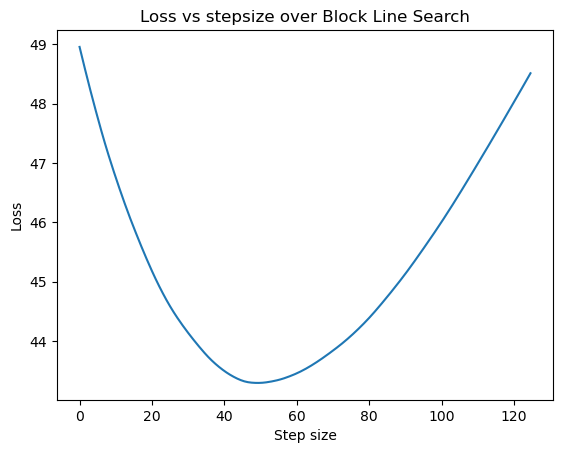

In [83]:
# plot for writeup
plt.plot(ls_hist['step_size'][:250], ls_hist['loss'][:250])
plt.xlabel('Step size')
plt.ylabel('Loss')
plt.title('Loss vs stepsize over Block Line Search')

In [11]:
def coord_step_linesearch(X_cur, i_k, g_ik, alpha:float):
    #hist_ls = []
    prev_loss = 1e10
    last_i = 0
    for i in range(100):
        step = - g_ik
        last_i = i
        X_cur[:,i_k] += alpha * step.flatten()
        l = fast_loss(A,b_onehot, X_cur)#
        # hist_ls.append({
        #     'iter': i,
        #     'loss': l
        # })
        if l > prev_loss:
            # by convexity, if the loss increases along our line search, stop searching.
            X_cur[:,i_k] -= alpha * step.flatten() # this is wastful: undoing work, but probably better than maintining the last X in memory
            break
        prev_loss = l
# ls_df = pd.DataFrame(hist_ls)
# ls_df
    return {'step_size': alpha * last_i, 'ls_steps':last_i}

In [16]:
hist_BCGD_GS_ls_df = BCGD(gs_coord_select, coord_step=coord_step_linesearch, max_iter=100, step_size=5)
hist_BCGD_GS_ls_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size,ls_steps
0,0,69.545816,0.039,8,0.260604,1.296875,0.270859,85,17
1,1,67.442374,0.066,16,0.241867,2.250000,0.499915,110,22
2,2,65.091393,0.087,29,0.243855,3.343750,0.679661,90,18
3,3,63.105823,0.109,11,0.238175,4.359375,0.865717,90,18
4,4,61.042762,0.132,30,0.237184,5.406250,1.066899,95,19
...,...,...,...,...,...,...,...,...,...
74,74,0.241348,0.984,33,0.047723,45.828125,9.045388,35,7
75,75,0.216904,0.986,21,0.047946,46.031250,9.102674,35,7
76,76,0.189037,0.987,12,0.045996,46.265625,9.152674,30,6
77,77,0.171564,0.988,41,0.043865,46.703125,9.230332,55,11


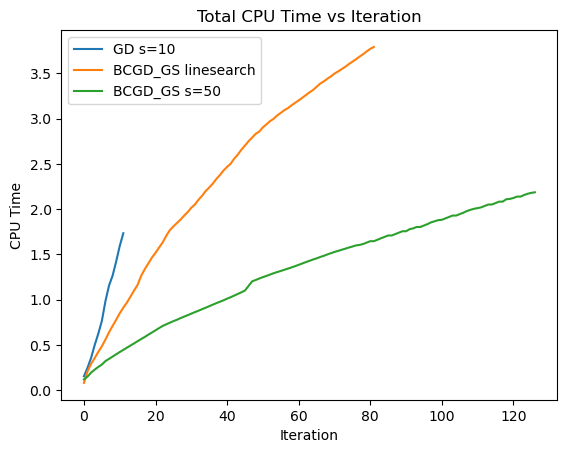

In [171]:
plt.plot(hist_gd_df['iter'], hist_gd_df['cpu_time'], label='GD s=10')
plt.plot(hist_BCGD_GS_ls_df['iter'],hist_BCGD_GS_ls_df['wall_time'], label='BCGD_GS linesearch')
plt.plot(hist_BCGD_GS_df['iter'],hist_BCGD_GS_df['wall_time'], label='BCGD_GS s=50')
plt.title('Total CPU Time vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('CPU Time')
plt.legend()

In [155]:
X0.shape

(1000, 50)

In [87]:
hist_BCGD_GS_ls_df['ls_steps'].mean()

5.217391304347826

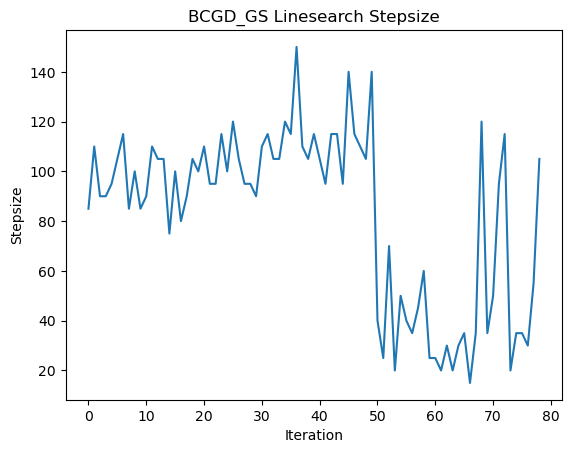

In [20]:
plt.plot(hist_BCGD_GS_ls_df['iter'], hist_BCGD_GS_ls_df['step_size'])
plt.xlabel('Iteration')
plt.ylabel('Stepsize')
plt.title('BCGD_GS Linesearch Stepsize')
plt.show()

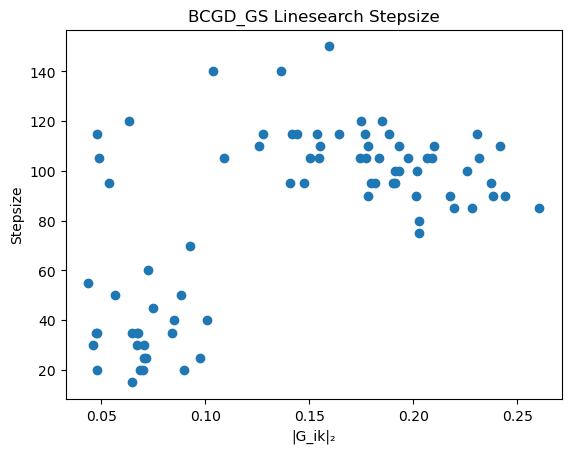

In [21]:
plt.scatter(hist_BCGD_GS_ls_df['L2_g_ik'], hist_BCGD_GS_ls_df['step_size'])
plt.xlabel('|G_ik|₂')
plt.ylabel('Stepsize')
plt.title('BCGD_GS Linesearch Stepsize')
plt.show()

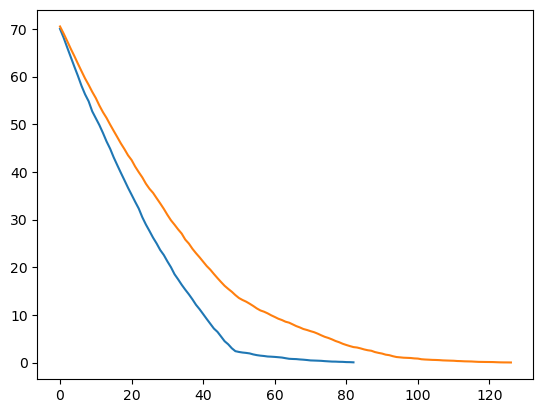

In [181]:
plt.figure()
plt.plot(hist_BCGD_GS_ls_df['iter'], hist_BCGD_GS_ls_df['loss'])
plt.plot(hist_BCGD_GS_df['iter'], hist_BCGD_GS_df['loss'])

In [40]:
hist_BCGD_rand_df = BCGD(rand_coord_select, max_iter=500, step_size=50)
hist_BCGD_rand_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size
0,0,72.430864,0.023,16,0.181109,0.218750,0.080076,50
1,1,70.852066,0.035,23,0.207706,0.421875,0.118219,50
2,2,69.665614,0.040,1,0.206103,0.593750,0.151754,50
3,3,68.779128,0.043,39,0.177169,0.718750,0.182755,50
4,4,67.838522,0.049,34,0.204537,0.921875,0.210752,50
...,...,...,...,...,...,...,...,...
392,392,0.809602,0.975,5,0.007836,30.281250,6.311254,50
393,393,0.803957,0.975,24,0.046073,30.328125,6.324482,50
394,394,0.803933,0.975,7,0.000909,30.406250,6.334009,50
395,395,0.803931,0.975,5,0.000197,30.453125,6.349402,50


In [77]:
def plot_hist(X_val, Y_val, dfs, legend_lables, title = None):
    # Checking optimality conditions
    # want to plot only the histories before cond. met.

    fig = plt.figure()
    for i, hist_df in enumerate(dfs):
        plt.plot(hist_df[X_val], hist_df[Y_val], label=legend_lables[i])
    # plt.plot(hist_gd_df[gd_sele][X_val], hist_gd_df[gd_sele][Y_val], label='GD')
    # plt.plot(hist_BCGD_GS_df[gs_sele][X_val], hist_BCGD_GS_df[gs_sele][Y_val], label='GS')
    # plt.plot(hist_BCGD_rand_df[rand_sele][X_val], hist_BCGD_rand_df[rand_sele][Y_val], label = 'Random')
    plt.legend()
    plt.xlabel(X_val)
    plt.ylabel(Y_val)
    if title is not None:
        plt.title(title)
    plt.show()

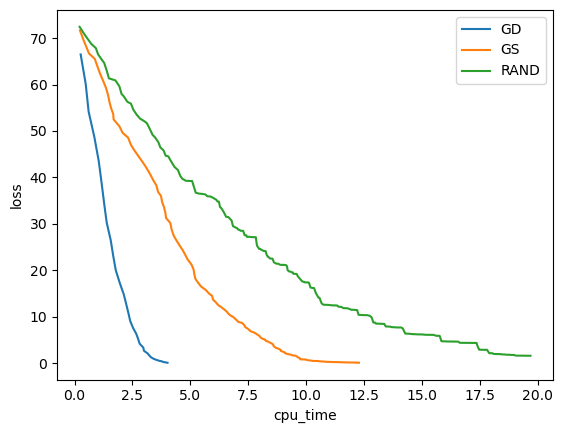

In [78]:
gd_sele = (hist_gd_df['grad_mag'] < 0.01).cumsum() == 0
gs_sele = (hist_BCGD_GS_df['L2_g_ik'] < 0.01).cumsum() == 0
rand_sele = (hist_BCGD_rand_df['L2_g_ik'] < 0.01).cumsum() < 30 # patience for random because prev. selected coords have low grad and can stop prematurely.
plot_hist('cpu_time', 'loss', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

In [47]:
import timeit

grad_times = []
for i in range(100):
    p_start = time.process_time()#timeit.timeit()
    w_start = time.time()
    grad(A,b_onehot,X0)
    p_end = time.process_time()#timeit.timeit()
    w_end = time.time()
    grad_times.append({'p_time':p_end-p_start, 'w_time':w_end-w_start})
grad_times = pd.DataFrame(grad_times)
grad_times.mean()

p_time    0.043437
w_time    0.008877
dtype: float64

In [46]:
block_times = []
for i in range(100):
    p_start = time.process_time()#timeit.timeit()
    w_start = time.time()
    grad_block(A,b_onehot,X0, 4)
    p_end = time.process_time()#timeit.timeit()
    w_end = time.time()
    block_times.append({'p_time':p_end-p_start, 'w_time':w_end-w_start})
block_times = pd.DataFrame(block_times)
block_times.mean()

p_time    0.062656
w_time    0.010988
dtype: float64

In [49]:
loss_times = []
for i in range(100):
    p_start = time.process_time()#timeit.timeit()
    w_start = time.time()
    loss(A,b_onehot,X0)
    p_end = time.process_time()#timeit.timeit()
    w_end = time.time()
    loss_times.append({'p_time':p_end-p_start, 'w_time':w_end-w_start})
loss_times = pd.DataFrame(loss_times)
loss_times.mean()

p_time    0.060781
w_time    0.011807
dtype: float64

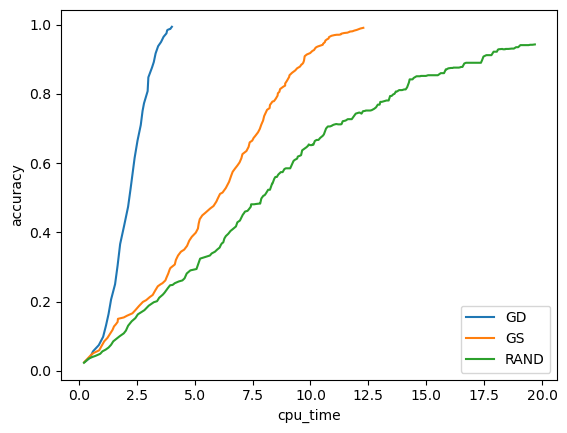

In [79]:
plot_hist('cpu_time', 'accuracy', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

In [140]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
iris = fetch_ucirepo(id=53) 
A_df = iris.data.features 
class_df = iris.data.targets 

In [141]:
b_names = class_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = class_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = A_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [150]:
gd_iris_df = gd(A, b_onehot, eta = 0.05)
gd_iris_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,7.035553,0.333333,7.047432,0.015625,0.012557
1,1,4.558378,0.333333,7.044138,0.031250,0.022314
2,2,2.234714,0.333333,6.987934,0.031250,0.023650
3,3,1.238078,0.566667,5.771684,0.031250,0.023650
4,4,0.930227,0.606667,2.821333,0.031250,0.024658
...,...,...,...,...,...,...
995,995,0.178251,0.960000,0.040241,1.359375,0.323812
996,996,0.178169,0.960000,0.040209,1.359375,0.323812
997,997,0.178086,0.960000,0.040178,1.359375,0.323812
998,998,0.178003,0.960000,0.040147,1.359375,0.323812


In [156]:
bcgd_gs_iris_df = BCGD(gs_coord_select, step_size=0.1, max_iter=1000)
bcgd_gs_iris_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,6.217491,0.333333,0,5.747779,0.000000,0.001000
1,1,2.961818,0.333333,0,5.741439,0.000000,0.008064
2,2,1.154846,0.326667,0,5.428457,0.000000,0.009106
3,3,0.917601,0.253333,1,1.941350,0.031250,0.009106
4,4,0.878882,0.666667,2,0.819899,0.031250,0.010146
...,...,...,...,...,...,...,...
995,995,0.174593,0.953333,2,0.028601,1.796875,0.374990
996,996,0.174511,0.953333,2,0.028570,1.828125,0.374990
997,997,0.174430,0.953333,2,0.028539,1.828125,0.374990
998,998,0.174348,0.953333,0,0.028533,1.843750,0.375990


In [163]:
bcgd_rand_iris_df = BCGD(rand_coord_select, step_size=0.1, max_iter=500)
bcgd_rand_iris_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,8.551884,0.333333,2,3.112061,0.000000,0.001749
1,1,7.584707,0.333333,2,3.111076,0.000000,0.002607
2,2,4.339738,0.333333,0,5.740180,0.000000,0.002607
3,3,3.642264,0.333333,1,2.641419,0.000000,0.007038
4,4,2.947723,0.333333,1,2.638836,0.000000,0.007038
...,...,...,...,...,...,...,...
495,495,0.294265,0.946667,0,0.044693,0.640625,0.147393
496,496,0.294069,0.946667,0,0.044370,0.640625,0.147393
497,497,0.293613,0.946667,2,0.067595,0.640625,0.147393
498,498,0.293538,0.946667,1,0.027815,0.640625,0.148756


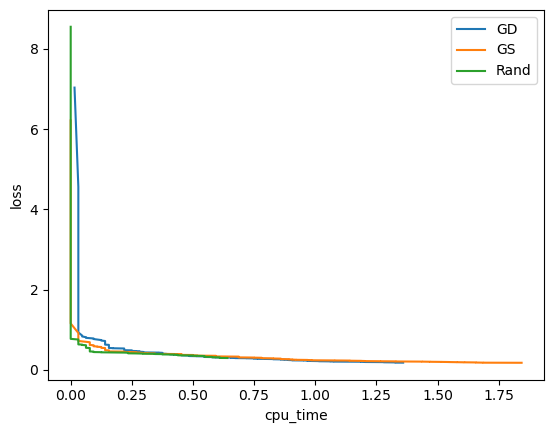

In [164]:
plot_hist('cpu_time', 'loss', [gd_iris_df, bcgd_gs_iris_df, bcgd_rand_iris_df], legend_lables=['GD', 'GS', 'Rand'])

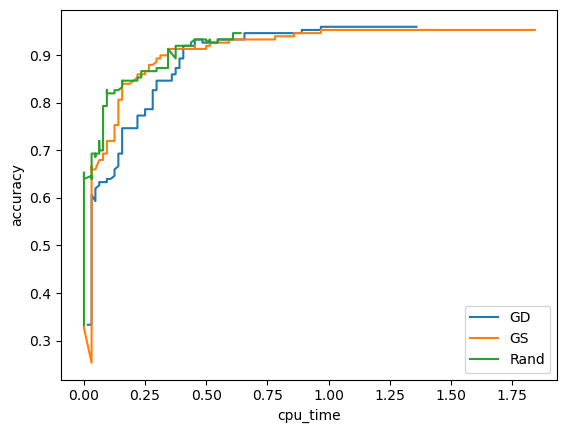

In [168]:
plot_hist('cpu_time', 'accuracy', [gd_iris_df, bcgd_gs_iris_df, bcgd_rand_iris_df], legend_lables=['GD', 'GS', 'Rand'])

In [12]:
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
digits_feats_df = optical_recognition_of_handwritten_digits.data.features / 16
digits_target_df = optical_recognition_of_handwritten_digits.data.targets 
 
digits_mask = digits_target_df['class'].isin([0,1,2,3,4])
digits_feats_df = digits_feats_df[digits_mask]
digits_target_df = digits_target_df[digits_mask]

In [13]:
digits_target_df

,class
0,0
1,0
3,4
5,2
8,0
...,...
5605,2
5606,2
5611,4
5614,4


In [45]:
b_names = digits_target_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = digits_target_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = digits_feats_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
lipschitz_approx(A)

29952.626530946007

In [67]:
step_size_digits = 1.5

In [68]:
digits_gd_df = gd(A,b_onehot, max_iter=1000, step_size=step_size_digits)

In [69]:
digits_bcgd_gs_df = BCGD(gs_coord_select, step_size=step_size_digits, max_iter=1000)

In [ ]:
digits_bcgd_gst_df = BCGD(gs_coord_select_T, step_size=2)

In [73]:
digits_bcgd_rand_df = BCGD(rand_coord_select, step_size=step_size_digits, max_iter=1000)

In [ ]:
digits_bcgd_gsls_df = BCGD(gs_coord_select,coord_step=coord_step_linesearch, step_size=0.1)

In [ ]:
digits_bcgd_randls_df = BCGD(rand_coord_select,coord_step=coord_step_linesearch, step_size=0.1)

In [82]:
28**2

784

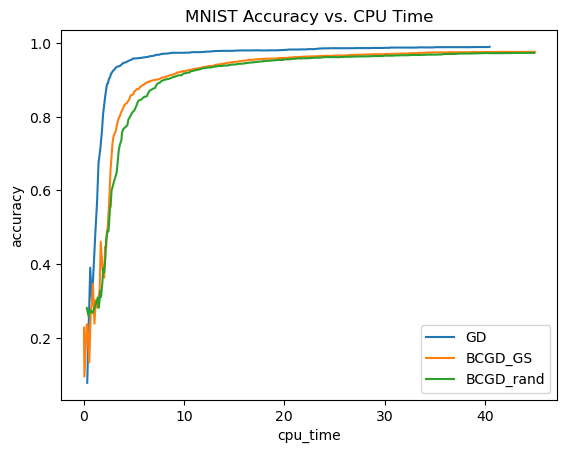

In [81]:
plot_hist('cpu_time', 'accuracy', [digits_gd_df, digits_bcgd_gs_df[digits_bcgd_gs_df['cpu_time'] < 45], digits_bcgd_rand_df[digits_bcgd_rand_df['cpu_time'] < 45]], ['GD', 'BCGD_GS', 'BCGD_rand'], title = "MNIST Accuracy vs. CPU Time")


In [66]:
digits_bcgd_gs_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size
0,0,3.934008,0.289511,1,0.893325,0.156250,0.023640,1.0
1,1,3.505552,0.160879,0,1.254178,0.250000,0.047803,1.0
2,2,3.241329,0.201984,2,0.596156,0.343750,0.070802,1.0
3,3,3.149079,0.162296,1,0.479503,0.437500,0.091844,1.0
4,4,2.887445,0.177534,4,0.550512,0.562500,0.111360,1.0
...,...,...,...,...,...,...,...,...
995,995,0.073309,0.981219,3,0.006574,116.703125,19.485414,1.0
996,996,0.073266,0.981219,4,0.006566,116.859375,19.504415,1.0
997,997,0.073223,0.981219,1,0.006566,116.984375,19.522930,1.0
998,998,0.073180,0.981219,4,0.006554,117.046875,19.541931,1.0


<Axes: >

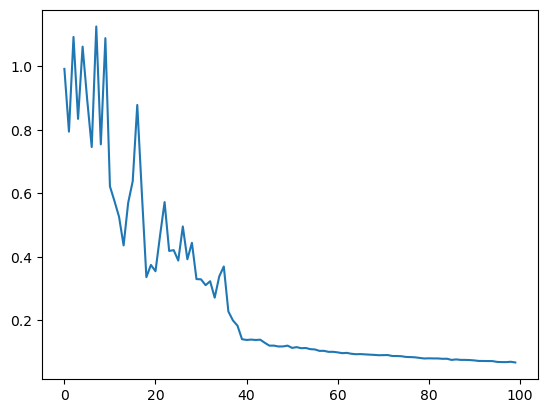

In [372]:
digits_bcgd_gs_df['L2_g_ik'].plot()

In [54]:
#grad(A, b_onehot, np.random.randn(0,1))
#L = []
#L_block = []
#L_block_norm = []
vars = [1]#, 0.5, 0.25, 0.1]
L_hist = []
for cur_var in vars:
    for i in range(100):
        X_rand = np.random.normal(0,0.5,size=(example_dim,num_classes))
        Y_rand = np.random.normal(0,0.5,size=(example_dim,num_classes))
        X_grad = grad(A, b_onehot, X_rand)
        Y_grad = grad(A, b_onehot, Y_rand)
        L_full = np.linalg.norm(X_grad - Y_grad,2)/np.linalg.norm(X_rand - Y_rand,2)
        #L.append(L_full)
        block_idx = np.random.randint(num_classes)
        X_grad_rand = grad_block(A, b_onehot, X_rand, block_idx)
        Y_grad_rand = grad_block(A, b_onehot, Y_rand, block_idx)
        X_grad_rand = grad_block(A, b_onehot, X_rand, block_idx)
        Y_grad_rand = grad_block(A, b_onehot, Y_rand, block_idx)
        L_block = np.linalg.norm(X_grad_rand - Y_grad_rand,2)/np.linalg.norm(X_rand - Y_rand,2)
        L_hist.append({'i':i, 'var':cur_var, 'L_full':L_full, 'block_idx':block_idx, 'L_block':L_block})
L_hist = pd.DataFrame(L_hist)

In [60]:
1 / L_hist['L_block'].mean()

144.16042123643118

In [50]:
1/max(L_block)

NameError: name 'L_block' is not defined

In [380]:
A.shape

(5620, 64)